In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from torch.utils.data import Dataset, DataLoader
from scipy.stats import zscore
from scipy.stats import ttest_ind
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm

from lstm_ae import *

In [29]:
df = pd.read_csv('data/sepsis_df.csv')
df = df.iloc[:,1:] # omit the extra index column

state_cols = ['gender', 'age', 'elixhauser', 're_admission',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'SOFA', 'SIRS', 'cumulated_balance']

In [30]:
# z-score normalization (and de-normalization for later)

# these are either id or binary-valued columns
dont_touch_columns = ['icustayid', 'gender', 're_admission', 'mechvent', 'died_in_hosp', 'vaso_bin', 'iv_bin', 'terminal_state']

# this will store means and stds for each columns
col_gaussians = {}

def normalize(col):
    if col.name in dont_touch_columns:
        return col
    else:
        global col_gaussians
        col_gaussians[col.name] = (col.mean(), col.std())
        return zscore(col)


def denormalize(col):
    if col.name in dont_touch_columns:
        return col
    else:
        mean, std = col_gaussians[col.name]
        return (col * std) + mean


real_df = df.copy()
df = df.apply(normalize)

In [31]:
# state space representation using a recurrent (LSTM) autoencoder


class SepsisStateDataset(Dataset):
    """
    Torch dataset for sepsis state space data. Returns a tensor sequence of data 
    with size (seq_len, n_features). If the sequence is shorter than seq_len, it is
    padded with -1.
    """
    def __init__(self, df, state_cols, seq_len):
        self.sequences = []
        self.lengths = []
        
        for icustayid, group in df.groupby('icustayid'):
            seq = group[state_cols].values.astype(np.float32)
            length = len(seq)

            # pad with -1 if necessary
            if length < seq_len:
                pad = np.full((seq_len - length, len(state_cols)), -1)
                seq = np.concatenate([seq, pad], axis=0)

            seq = torch.tensor(seq, dtype=torch.float32)

            self.sequences.append(seq)
            self.lengths.append(length)

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx]


def collate_fn(batch):
    sequences, lengths = zip(*batch)
    return torch.stack(sequences), torch.tensor(lengths)



SEQ_LEN = df['icustayid'].value_counts().max() # max # of datapoints for any patient in sepsis_df | 20
BATCH_SIZE = 64
LR = 0.001
N_EPOCHS = 500
N_FEATURES = len(state_cols) # 46
HIDDEN_DIM = 64
LATENT_DIM = 20

# split on ids to prevent splitting halfway through a trajectory | 70/10/20 split
icustayids = df['icustayid'].unique()
random.shuffle(icustayids)
cutoff1 = int(0.7 * len(icustayids))
cutoff2 = int(0.8 * len(icustayids))

train_ids = icustayids[:cutoff1]
train_df = df[df['icustayid'].isin(train_ids)]
train_dataset = SepsisStateDataset(train_df, state_cols, SEQ_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_ids = icustayids[cutoff1:cutoff2]
val_df = df[df['icustayid'].isin(val_ids)]
val_dataset = SepsisStateDataset(val_df, state_cols, SEQ_LEN)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

test_ids = icustayids[cutoff2:]
test_df = df[df['icustayid'].isin(test_ids)]
test_dataset = SepsisStateDataset(test_df, state_cols, SEQ_LEN)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMAE(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)


# TODO: switch this to using lengths as a mask
def masked_mse_loss(output, target, pad_value=-1):
    """ Ignores any -1 values """
    mask = (target != pad_value)
    diff = (output - target)[mask]
    return torch.sum(diff**2) / torch.sum(mask)

In [32]:
# train and validate

train_losses = []
val_losses = []

for epoch in tqdm(range(N_EPOCHS)):
    model.train()
    total_loss = 0
    for batch, lengths in train_dataloader:
        batch = batch.to(device) # (batch_size, sequence_length, num_features)
        optimizer.zero_grad()
        output = model(batch, lengths) # (batch_size, sequence_length, num_features)
        loss = masked_mse_loss(output, batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss)

    # validate every 50 epochs
    if epoch % 50 == 0:
        model.eval()
        total_loss = 0
        for batch, lengths in val_dataloader:
            batch = batch.to(device) # (batch_size, sequence_length, num_features)
            output = model(batch, lengths) # (batch_size, sequence_length, num_features)
            loss = masked_mse_loss(output, batch)
            total_loss += loss.item()

        val_losses.append(total_loss)
        
    #print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {total_loss/len(dataloader)}')


100%|█████████████████████████████████████████| 500/500 [59:04<00:00,  7.09s/it]


In [33]:
# test

test_losses = []
model.eval()
for epoch in tqdm(range(N_EPOCHS)):
    total_loss = 0
    for batch, lengths in test_dataloader:
        batch = batch.to(device) # (batch_size, sequence_length, num_features)
        output = model(batch, lengths) # (batch_size, sequence_length, num_features)
        loss = masked_mse_loss(output, batch)
        total_loss += loss.item()
        
    test_losses.append(total_loss)
    #print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {total_loss/len(dataloader)}')


100%|█████████████████████████████████████████| 500/500 [02:14<00:00,  3.71it/s]


mean train loss: 55.20748786526919
mean val loss: 10.661409875750541
mean test loss: 18.689588740468025


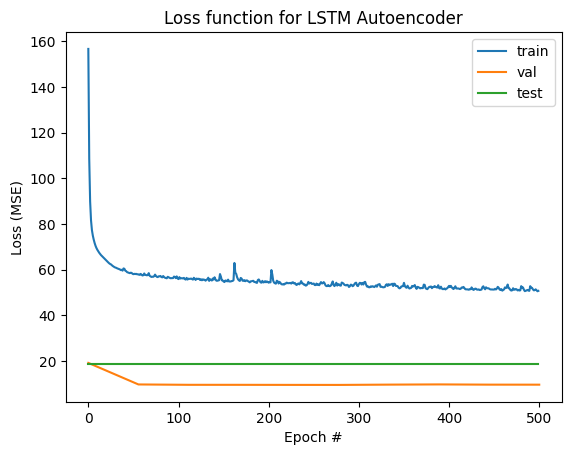

In [34]:
plt.plot(train_losses, label='train')
plt.plot(np.linspace(0, 500, 10), val_losses, label='val')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss function for LSTM Autoencoder')
plt.legend()

print(f'mean train loss: {np.mean(train_losses)}')
print(f'mean val loss: {np.mean(val_losses)}')
print(f'mean test loss: {np.mean(test_losses)}')

In [36]:
# careful, only run this if you want to overwrite the last model

#torch.save(model.encoder.state_dict(), 'models/lstm_encoder.pth')
#torch.save(model.decoder.state_dict(), 'models/lstm_decoder.pth')

In [37]:
# get the latent state representation for each timepoint, for each patient

dataset = SepsisStateDataset(df, state_cols, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

encoder = Encoder(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
encoder.load_state_dict(torch.load('models/lstm_encoder.pth', weights_only=True))
encoder.to(device)
encoder.eval()

decoder = Decoder(input_dim=N_FEATURES, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, seq_len=SEQ_LEN)
decoder.load_state_dict(torch.load('models/lstm_decoder.pth', weights_only=True))
decoder.to(device)
decoder.eval()

latent_vectors = []
rec_states = []

for batch, lengths in dataloader:
    batch = batch.to(device) # batch: (batch_size, sequence_length, num_features)
    optimizer.zero_grad()

    # save latents
    latents, _ = encoder(batch, lengths, return_all_latents=True) # latents: (batch_size, sequence_length, latent_dim)
    for latent in latents: # latent: (total_num_of_timesteps_for_sequence_length_patients, latent_dim)
        latent_vectors.append(latent.detach().numpy()) # latent: (latent_dim,)

    # save reconstructed states
    x_enc, _ = encoder(batch, lengths)
    x_dec, _ = decoder(x_enc, lengths, return_all_reconstructions=True)
    for rec_state in x_dec:
        rec_states.append(rec_state.detach().numpy())
        

In [38]:
latent_vectors = np.array(latent_vectors)
print(latent_vectors.shape) # (total_num_of_timesteps, latent_dim) = (264589, 20)

latent_col_names = [f'latent_{num}' for num in range(1, 21)]
latent_df = pd.DataFrame(latent_vectors, columns=latent_col_names)
latent_df.insert(0, 'icustayid', df['icustayid'])
latent_df.insert(1, 'died_in_hosp', df['died_in_hosp'])
latent_df.insert(2, 'terminal_state', df['terminal_state'])
latent_df.to_csv('data/latent_states.csv')
latent_df

(264589, 20)


,icustayid,died_in_hosp,terminal_state,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,...,latent_11,latent_12,latent_13,latent_14,latent_15,latent_16,latent_17,latent_18,latent_19,latent_20
0,3,0,0,0.852851,0.563392,0.486794,-0.259612,0.069543,0.282163,-0.189017,...,0.085820,-0.217873,-0.169819,0.324762,0.311876,-0.240876,-0.492005,-0.197883,0.165773,0.422213
1,3,0,0,0.790614,0.625270,0.375349,-0.226509,0.092939,0.206643,-0.064207,...,0.009296,-0.250763,-0.004630,0.181777,0.254708,-0.274098,-0.557850,-0.180160,0.290115,0.405147
2,3,0,0,0.820196,0.646060,0.315903,-0.248454,0.098474,0.187858,-0.011280,...,0.011502,-0.225928,-0.002408,0.215145,0.313168,-0.321094,-0.500078,-0.199212,0.338405,0.405850
3,3,0,0,0.799095,0.673331,0.284607,-0.255464,0.093584,0.181104,0.002208,...,-0.002294,-0.225360,0.026714,0.206668,0.322204,-0.327040,-0.490794,-0.215061,0.356390,0.385922
4,3,0,0,0.791212,0.666611,0.274091,-0.242495,0.065436,0.192217,0.024918,...,-0.011268,-0.225883,0.035692,0.197771,0.337680,-0.328328,-0.475957,-0.204854,0.350387,0.390293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264584,99995,0,0,0.123977,0.220395,0.267887,0.150685,-0.091297,-0.028640,-0.434448,...,-0.442245,-0.041718,0.524945,-0.163512,-0.217532,0.303513,-0.137960,-0.330630,0.052874,0.219699
264585,99995,0,0,0.137777,0.263879,0.263322,0.172594,-0.103602,-0.042879,-0.424294,...,-0.434501,-0.032889,0.527513,-0.163988,-0.226133,0.271273,-0.135366,-0.345667,0.052259,0.237246
264586,99995,0,0,0.148845,0.309272,0.260256,0.162163,-0.122467,-0.055617,-0.413843,...,-0.430081,-0.015466,0.533123,-0.173991,-0.226597,0.267106,-0.144779,-0.368742,0.072701,0.233345
264587,99995,0,0,0.151981,0.337542,0.262146,0.163324,-0.143370,-0.075428,-0.411634,...,-0.432054,-0.001827,0.538859,-0.181981,-0.240376,0.248512,-0.128008,-0.383020,0.081130,0.233390


In [40]:
rec_states = np.array(rec_states).reshape(-1, 46)
print(rec_states.shape) # (total_num_of_timesteps, n_features) = (264589, 44)

# TODO: check column names line up!!
rec_states_df = pd.DataFrame(rec_states, columns=state_cols)
rec_states_df = rec_states_df.apply(denormalize)
rec_states_df.insert(0, 'icustayid', df['icustayid'])
rec_states_df.insert(1, 'died_in_hosp', df['died_in_hosp'])
rec_states_df.insert(2, 'terminal_state', df['terminal_state'])
rec_states_df.to_csv('data/rec_states.csv')
rec_states_df

(264589, 46)


,icustayid,died_in_hosp,terminal_state,gender,age,elixhauser,re_admission,Weight_kg,GCS,HR,...,paCO2,Arterial_BE,Arterial_lactate,HCO3,mechvent,Shock_Index,PaO2_FiO2,SOFA,SIRS,cumulated_balance
0,3,0,0,0.298938,19470.167969,-0.278735,0.192169,79.164810,14.581287,83.369316,...,39.248112,4.926104,1.466019,28.984201,0.134648,0.709508,274.688263,5.525141,1.623190,-3092.348389
1,3,0,0,0.201147,17972.140625,-0.377797,0.203789,82.747620,14.510218,80.836441,...,37.634563,5.427976,1.417790,29.400059,0.245230,0.697294,262.362122,5.547217,1.657845,-2271.599365
2,3,0,0,0.175115,18045.113281,-0.427991,0.176067,82.671585,14.723147,78.737068,...,37.960163,5.113214,1.417083,29.256958,0.233874,0.676551,270.535950,5.676188,1.634589,-1569.803711
3,3,0,0,0.146041,18307.228516,-0.450313,0.160881,83.387428,14.670639,77.612724,...,38.368019,5.202065,1.421531,29.351095,0.205369,0.659459,277.464783,5.579615,1.642179,-520.863770
4,3,0,0,0.122773,18269.923828,-0.492601,0.151469,83.461227,14.753934,76.823822,...,38.512959,5.161168,1.415036,29.309988,0.183065,0.647251,282.420197,5.557913,1.635707,198.984924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264584,99995,0,0,0.364809,12131.918945,-0.844200,-0.048725,86.569313,14.905086,87.524567,...,40.144455,4.186465,1.388729,26.152048,0.245304,0.681088,346.048065,1.608656,1.964001,2872.505371
264585,99995,0,0,0.356172,12167.365234,-0.825538,-0.049097,86.700638,14.972859,87.114586,...,40.208324,4.191492,1.390716,26.208447,0.224715,0.675981,351.030670,1.515419,1.948992,2677.488281
264586,99995,0,0,0.349376,12174.072266,-0.794966,-0.047374,86.678947,15.022328,86.731148,...,40.258739,4.177332,1.397207,26.235270,0.208231,0.671865,354.256165,1.451372,1.933753,2498.194824
264587,99995,0,0,0.341721,12180.673828,-0.779942,-0.047910,86.665497,15.060323,86.422348,...,40.312630,4.168874,1.400561,26.267130,0.195103,0.668535,356.747589,1.404613,1.921244,2335.881348


In [41]:
# visualize latent space with t-sne

latent_tsne = TSNE(n_components=2).fit_transform(latent_vectors)

In [42]:
latent_tsne_df = pd.DataFrame(data={
    'tsne_1': latent_tsne[:, 0],
    'tsne_2': latent_tsne[:, 1],
    'died_in_hosp': df['died_in_hosp'].values,
    'gender': df['gender'].values,
    'age_bin': (df['age'] > df['age'].mean()).astype(int),
    'SOFA': np.digitize(df['SOFA'].values, list(range(20))),
    'vasos': df['vaso_bin'].values,
    'IVs': df['iv_bin'].values
})

latent_tsne_df

,tsne_1,tsne_2,died_in_hosp,gender,age_bin,SOFA,vasos,IVs
0,-4.333815,-35.663395,0,0,0,0,0,2
1,-4.332465,-35.680737,0,0,0,0,0,2
2,-4.355684,-35.689590,0,0,0,0,0,2
3,-4.362879,-35.695332,0,0,0,0,0,2
4,-4.366119,-35.697132,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...
264584,-19.000805,33.278206,0,0,0,0,0,0
264585,-18.997559,33.275570,0,0,0,0,0,0
264586,-18.997278,33.272449,0,0,0,0,0,0
264587,-18.996202,33.272697,0,0,0,0,0,0


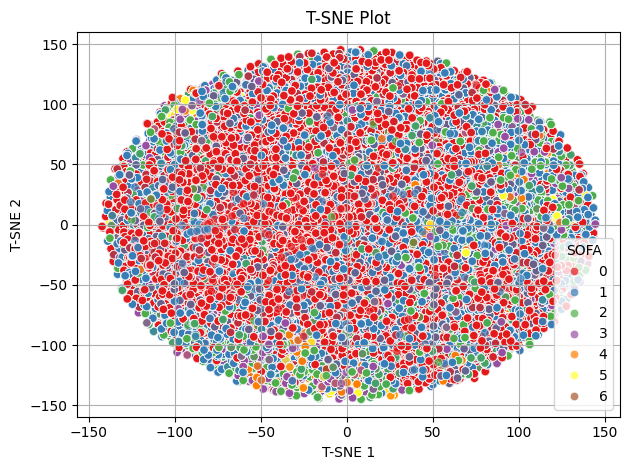

In [43]:
#plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='SOFA',
    palette='Set1',
    data=latent_tsne_df,
    alpha=0.7
)
plt.title('T-SNE Plot')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend(title='SOFA')
plt.grid(True)
plt.tight_layout()
plt.show()

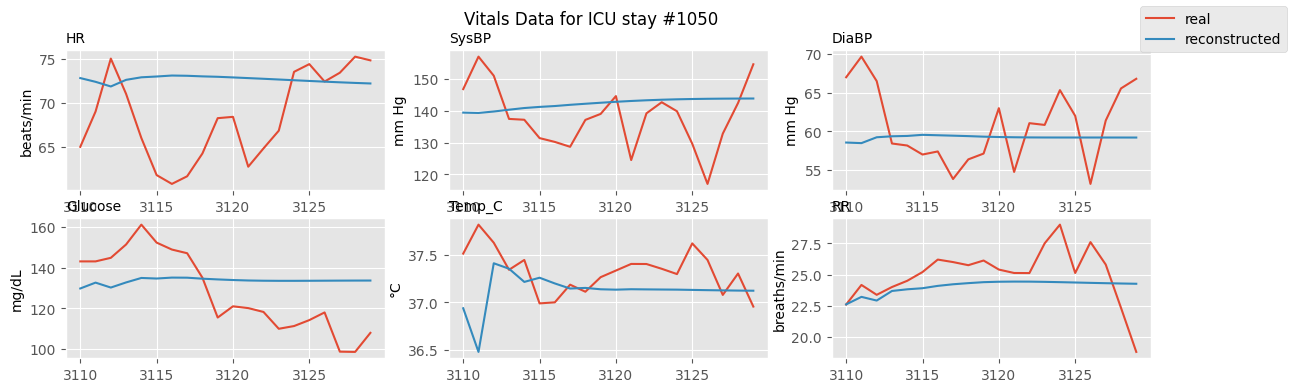

,age,gender,Weight_kg,elixhauser
real,83.706849,1.000000,75.400002,2.000000
reconstructed,80.245719,0.355198,70.473137,2.025841


In [75]:
# visualize patient trajectories!
 

stats = ['HR', 'SysBP', 'DiaBP', 'Glucose', 'Temp_C', 'RR']
units = {'HR': 'beats/min', 'SysBP': 'mm Hg', 'DiaBP': 'mm Hg', 'Glucose': 'mg/dL', 'Temp_C': '°C', 'RR': 'breaths/min'}

def plot_trajectory(idx):
    
    patient_df = real_df[real_df['icustayid'] == idx]
    reconstructed_df = rec_states_df[rec_states_df['icustayid'] == idx]

    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, 3, figsize=(14,4))
    fig.suptitle(f'Vitals Data for ICU stay #{idx}')
    
    for ax, stat in zip(axs.flat, stats):
        ax.plot(patient_df[stat], label='real')
        ax.plot(reconstructed_df[stat], label='reconstructed')
        ax.set_title(stat, fontsize='medium', color='black', loc='left')
        ax.set_ylabel(units[stat], fontsize='medium', color='black')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()


def get_demographics(idx):

    patient_row = real_df[real_df['icustayid'] == idx].iloc[0]
    reconstructed_row = rec_states_df[rec_states_df['icustayid'] == idx].iloc[0]
    demographics = ['age', 'gender', 'Weight_kg', 'elixhauser']

    summary = pd.DataFrame({'real': patient_row[demographics], 'reconstructed': reconstructed_row[demographics]}).transpose()
    summary['age'] /= 365 # days --> years

    return summary
    

plot_trajectory(1050)
get_demographics(1050)
